## 랜덤 포레스트

- 앙상블 알고리즘 중 비교적 빠른 수행 속도를 가짐

- 기반 알고리즘은 결정 트리, 그래서 쉽고 직관적인 장점을 그대로 가짐

- 여러 개의 결정 트리 classifier가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측 결정을 하게 됨

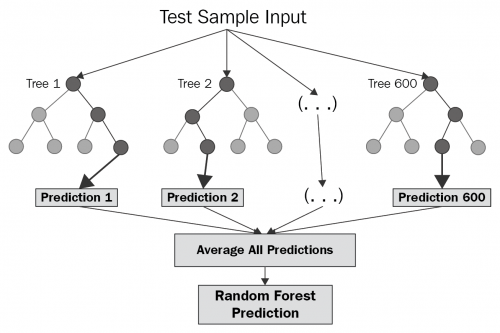

- 랜덤 포레스트는 개별 분류기의 기반은 결정 트리이지만 개별 트리가 학습하는 데이터셋은 일부가 중첩되게 샘플링되었음 >> 부트스트래핑 분할 방식

- 서브세트 데이터는 부트스트래핑으로 임의로 만들어짐

- 서브세트 데이터 건수는 전체 데이터 건수와 동일하지만, 개별 데이터가 중첩됨

- 사이킷런은 RandomForestClassifier 클래스를 지원

In [1]:
from google.colab import files

uploaded = files.upload()

Saving X_test.txt to X_test.txt
Saving y_test.txt to y_test.txt


In [13]:
from google.colab import files

uploaded = files.upload()

Saving X_train.txt to X_train.txt
Saving y_train.txt to y_train.txt


In [14]:
from google.colab import files

uploaded = files.upload()

Saving features.txt to features (1).txt


In [15]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

In [23]:
import pandas as pd

def get_human_dataset():
  feature_name_df = pd.read_csv('/content/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  X_train = pd.read_csv('/content/X_train.txt', sep='\s+', names=feature_name)
  X_test = pd.read_csv('/content/X_test.txt', sep='\s+', names=feature_name)

  y_train = pd.read_csv('/content/y_train.txt', sep='\s+', header=None, names=['action'])
  y_test = pd.read_csv('/content/y_test.txt', sep='\s+', header=None, names=['action'])

  return X_train, X_test, y_train, y_test

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#결정 트리에서 사용한 get_human_dataset() 이용해 학습, 테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

#랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9196


### 랜덤 포레스트 하이퍼 파라미터 및 튜닝

- 트리 기반의 앙상블 단점 >> 하이퍼 파라미터가 너무 많아서 튜닝을 위한 시간이 소모된다는 것

- n_estimators: 랜덤 포레스트의 결정 트리 개수를 지정, 디폴트는 10개, 많을수록 좋은 성능을 기대할 수 있지만 수행 시간이 오래 걸림

- max_features: 결정트리의 파라미터와 동일, 다만 디폴트가 None이 아닌 auto, 즉 sqrt와 같음

- max_depth나 min_samples_split, min_samples_leaf와 같이 과적합 개선 용도의 파라미터는 랜덤포레스트에도 똑같이 적용 가능

#### GridSearchCV를 이용해 랜덤포레스트의 하이퍼 파라미터 튜닝하기

1.  시간 절약을 위해 n_estimators=100으로 CV=2로 설정

In [25]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [8, 16, 24], 'min_samples_split':[2, 8, 16], 'min_samples_leaf': [1, 6, 12] }

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, cv=2, param_grid=params, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도: 0.9165


- max_depth=16, min_samples_leaf=6, min_samples_split=2일 때 2개의 cv세트에서 약 91.65%의 평균 정확도가 측정됌

2. 이렇게 추출된 하이퍼 파라미터로 다시 RandomForestClassifier를 학습시킨 뒤에 별도의 테스트 데이터셋에서 예측 성능을 측정해보자

In [29]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9260


3. feature_importance_ 속성을 이용해 피처 중요도 알아보고 시각화하기

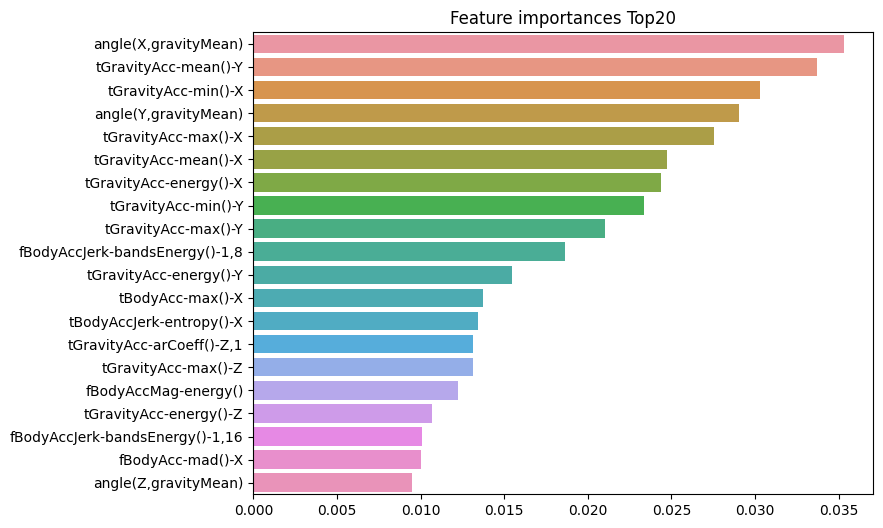

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()